In [1]:
import os
import torch
import json
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn as nn
from torchsummary import summary

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
DATA_ROOT = '/Users/longhoang/Developer/table-reg/data/scitsr-small'
DATA_TRAIN = os.path.join(DATA_ROOT, 'train')
IMGS_TRAIN = os.path.join(DATA_TRAIN, 'img')
LABELS_TRAIN = os.path.join(DATA_TRAIN, 'label', 'merge-label.json')

with open(LABELS_TRAIN, 'r') as f:
    merge_labels_train = json.load(f)

len(merge_labels_train)

64

In [13]:
class MergeDataset(Dataset):
    def __init__(self, img_dir, labels_dict, output_width=None,
                 scale=0.5, min_width=40, mode='split', suffix='png'):
        """
        Args:
            img_dir (str) -- the directory of images
            labels_dict (dict) -- dictionary where keys are images' names 
                                and values are ground truths
            output_width (int) -- width of output tensor
            scale (float) -- scale to resize original image
            min_width (int) -- minimum width of the resized image
            mode (str) -- 'split' or 'merge'
        """
        super().__init__()
        self.labels_dict = labels_dict
        self.ids = list(labels_dict.keys()) # list of image names
        self.n_samples = len(self.ids)
        self.img_dir = img_dir
        self.output_width = output_width
        self.scale = scale
        self.min_width = min_width
        self.mode = mode
        self.suffix = suffix

    def __len__(self): return self.n_samples

    def __getitem__(self, index):
        assert index <= len(self), 'Index range error'
        img_name = self.ids[index]
        if self.suffix != 'png':
            print('Only support `png` suffix currently')
            return None
        else:
            img = cv.imread(os.path.join(self.img_dir, img_name + '.' + self.suffix ))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = img.transpose((2,0,1))
        
        c, h, w = img.shape
        h_new = int(self.scale * h) if int(self.scale * h) > self.min_width \
                                    else self.min_width
        w_new = int(self.scale * w) if int(self.scale * w) > self.min_width \
                                    else self.min_width
        img = np.array([
            cv.resize(img[i], (w_new, h_new), interpolation=cv.INTER_AREA)
            for i in range(c)
        ])
        img_array = img / 255.

        labels = self.labels_dict[img_name]
        rows = labels['rows']
        columns = labels['columns']
        h_matrix = labels['h_matrix']
        v_matrix = labels['v_matrix']

        img_tensor = torch.from_numpy(img_array).type(torch.float)
        h_matrix = torch.from_numpy(np.array(h_matrix)).type(torch.float)
        v_matrix = torch.from_numpy(np.array(v_matrix)).type(torch.float)

        return img_tensor, (h_matrix, v_matrix), (rows, columns)


In [14]:
merge_train_dataset = MergeDataset(IMGS_TRAIN, merge_labels_train, scale=1)

torch.Size([3, 83, 394])


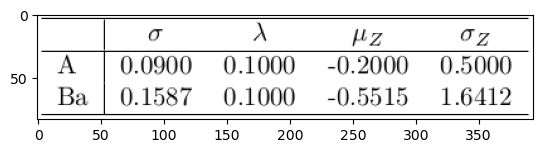

In [18]:
img_sample, (h_matrix, v_matrix), (rows, columns) = merge_train_dataset[0]
print(img_sample.shape)
plt.imshow(img_sample.cpu().numpy().transpose((1,2,0)))

In [7]:
class SharedFC(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 18, 7, stride=1, padding=3, bias=False),
            nn.ReLU(True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(18, 18, 7, stride=1, padding=3, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(18, 18, 7, stride=1, padding=3, bias=False),
            nn.ReLU(True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(18, 18, 7, stride=1, padding=3, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        return self.conv4(self.conv3(self.conv2(self.conv1(x))))

In [8]:
sharedFC_model = SharedFC().to(device)

print(summary(sharedFC_model, (3, 40, 320)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 18, 40, 320]         --
|    └─Conv2d: 2-1                       [-1, 18, 40, 320]         2,646
|    └─ReLU: 2-2                         [-1, 18, 40, 320]         --
├─Sequential: 1-2                        [-1, 18, 20, 160]         --
|    └─Conv2d: 2-3                       [-1, 18, 40, 320]         15,876
|    └─ReLU: 2-4                         [-1, 18, 40, 320]         --
|    └─MaxPool2d: 2-5                    [-1, 18, 20, 160]         --
├─Sequential: 1-3                        [-1, 18, 20, 160]         --
|    └─Conv2d: 2-6                       [-1, 18, 20, 160]         15,876
|    └─ReLU: 2-7                         [-1, 18, 20, 160]         --
├─Sequential: 1-4                        [-1, 18, 10, 80]          --
|    └─Conv2d: 2-8                       [-1, 18, 20, 160]         15,876
|    └─ReLU: 2-9                         [-1, 18, 20, 160]         --


In [12]:
class ProjectionNet(nn.Module):
    def __init__(self, in_channels, sigmoid=False, dropout=0.5):
        super().__init__()
        self.conv_branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 6, 3, stride=1, padding=1, dilation=1),
            nn.GroupNorm(3, 6),
            nn.ReLU(True)
        )
        self.conv_branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 6, 3, stride=1, padding=1, dilation=2),
            nn.GroupNorm(3, 6),
            nn.ReLU(True)
        )
        self.conv_branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 6, 3, stride=1, padding=1, dilation=3),
            nn.GroupNorm(3, 6),
            nn.ReLU(True)
        )
        self.sigmoid = sigmoid
        self.project_module = ProjectionModule(18, sigmoid, dropout)

    def forward(self, x, arc):
        '''
        Args:
            x (torch.tensor) -- input tensor of shape (B, C, H, W)
            arc (list(torch.tensor)) -- row and col predictions from Split module
        Returns:
            output (torch.tensor) -- same shape as input tensor
            matrix (torch.tensor) -- matrix of shape M x N
                                        where M is the number of rows
                                              N is the number of columns
        '''
        out = torch.cat(
            [m(x) for m in [self.conv_branch1, self.conv_branch2, self.conv_branch3]],
            dim=1
        )
        out, matrix = self.project_module(out, arc)
        if self.sigmoid: # NOTE: check this again
            return out, matrix
        else:
            return out
        
class ProjectionModule(nn.Module):
    def __init__(self, in_channels, sigmoid=False, dropout=0.5):
        super().__init__()
        self.sigmoid = sigmoid
        self.feat_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, bias=False),
            nn.GroupNorm(6, in_channels),
            nn.ReLU(True)
        )
        self.pred_conv = nn.Sequential(
            nn.Dropout2d(dropout), # NOTE: why dropout here ?
            nn.Conv2d(in_channels, 1, 1, bias=False)
        )
        self.feat_project = GridProjectPooling()
        self.pred_project = GridProjectPooling()
        self.sigmoid_layer = nn.Sigmoid()

    def forward(self, x, arc):
        base_input = x
        # branch 1 & 2
        feat = self.feat_conv(base_input)
        feat, _ = self.feat_project(feat, arc)
        out = [base_input, feat]
        # branch 3
        if self.sigmoid:
            pred = self.pred_conv(base_input)
            pred, matrix = self.pred_project(pred, arc)
            pred = self.sigmoid_layer(pred)
            matrix = self.sigmoid_layer(matrix)
            out.append(pred)
            out = torch.cat(out, 1)
            return out, matrix
        else:
            out = torch.cat(out, 1)
            return out
        
class GridProjectPooling(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
    
    def forward(self, x, arc):
        '''
        Args:
            x (torch.tensor) -- input tensor of shape (B, C, H, W)
            arc (list(torch.tensor)) -- row and col are binary predictions from Split module
                                        for example [1, 1, 1, 0, 0, 1, 1, 0, ...]
        Returns:
            output (torch.tensor) -- same shape as input tensor
            matrix (torch.tensor) -- matrix of shape M x N
                                        where M is the number of rows
                                              N is the number of columns
        '''
        b, c, h, w = x.shape
        h_line, v_line = arc
        self.h_line = [torch.tensor([0.], dtype=torch.double, device=self.device)] \
                    + h_line \
                    + [torch.tensor([1.], dtype=torch.double, device=self.device)]
        self.v_line = [torch.tensor([0.], dtype=torch.double, device=self.device)] \
                    + v_line \
                    + [torch.tensor([1.], dtype=torch.double, device=self.device)]
        self.h_line = (self.h_line * h).round().type(torch.int)
        self.v_line = (self.v_line * w).round().type(torch.int)

        rows = [self.h_line[i + 1] - self.h_line[i] 
                for i in range(len(self.h_line) - 1)]
        columns = [self.v_line[i + 1] - self.v_line[i] 
                   for i in range(len(self.v_line) - 1)]
        slices = torch.split(x, rows, 2) # ERROR
        means = [torch.mean(y, 2).unsqueeze(2) for y in slices]
        matrix = torch.cat(means, 2)
        blocks = [means[i].repeat(1, 1, rows[i], 1) for i in range(len(means))]
        block = torch.cat(blocks, 2)

        means = [torch.mean(y, 3).unsqueeze(3) for y in torch.split(matrix, columns, 3)]
        matrix = torch.cat(means, 3)
        block_mean = [torch.mean(y, 3).unsqueeze(3) for y in torch.split(block, columns, 3)]
        blocks = [block_mean[i].repeat(1, 1, 1, columns[i]) for i in range(len(block_mean))]
        output = torch.cat(blocks, 3)
        return output, matrix